>
> # MaaSSim tutorial

 ### quickstart

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys # add MaaSSim to path (not needed if MaaSSim is already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

prepare

In [19]:
from MaaSSim.utils import get_config, load_G, prep_supply_and_demand, generate_demand, generate_vehicles, initialize_df  # simulator
from MaaSSim.data_structures import structures as inData
from MaaSSim.simulators import simulate
from MaaSSim.visualizations import plot_veh
from MaaSSim.shared import prep_shared_rides
from MaaSSim.maassim import Simulator
import logging

In [3]:
import pandas as pd

In [4]:
import ExMAS

In [5]:
params = get_config('../../data/config/delft.json')  # load configuration

In [6]:
params.times.pickup_patience = 3600 # 1 hour of simulation
params.simTime = 4 # 1 hour of simulation
params.nP = 500 # reuqests (and passengers)
params.nV = 100 # vehicles

In [7]:
params.t0 = pd.Timestamp.now()
params.shareability.avg_speed = params.speeds.ride
params.shareability.shared_discount = 0.3
params.shareability.delay_value = 1
params.shareability.WtS = 1.3
params.shareability.price = 1.5 #eur/km
params.shareability.VoT = 0.0035 #eur/s
params.shareability.matching_obj = 'u_pax' #minimize VHT for vehicles
params.shareability.pax_delay = 0
params.shareability.horizon = 600
params.shareability.max_degree = 4
params.shareability.nP = params.nP
params.shareability.share = 1
params.shareability.without_matching = True

In [8]:
inData = load_G(inData, params)  # load network graph 

In [27]:
params.paths.platforms = "../../data/platforms.csv"
inData = generate_demand(inData, params, avg_speed = False)
inData.vehicles = generate_vehicles(inData,params.nV)
inData.vehicles.platform = 1
inData.passengers.platforms = inData.passengers.apply(lambda x: [0], axis = 1)
inData.requests['platform'] = inData.requests.apply(lambda row: inData.passengers.loc[row.name].platforms[0], axis = 1) 
inData.platforms = pd.read_csv(params.paths.platforms, index_col=0)
params.shareability.share = 1
params.shareability.without_matching = True

In [28]:
inData = ExMAS.main(inData, params.shareability, plot=False) # create shareability graph (ExMAS) 

07-05-21 10:46:21-INFO-Initializing pairwise trip shareability between 500 and 500 trips.
07-05-21 10:46:21-INFO-creating combinations
07-05-21 10:46:21-INFO-249500	 nR*(nR-1)
07-05-21 10:46:27-INFO-Reduction of feasible pairs by 99.76%
07-05-21 10:46:27-INFO-Degree 2 	Completed
07-05-21 10:46:27-INFO-trips to extend at degree 2 : 1519
07-05-21 10:46:29-INFO-At degree 2 feasible extensions found out of 216 searched
07-05-21 10:46:29-INFO-Degree 3 	Completed
07-05-21 10:46:29-INFO-trips to extend at degree 3 : 216
07-05-21 10:46:29-INFO-At degree 3 feasible extensions found out of 13 searched
07-05-21 10:46:29-INFO-Degree 4 	Completed
07-05-21 10:46:29-INFO-Max degree reached 4
07-05-21 10:46:29-INFO-Trips still possible to extend at degree 4 : 13


In [29]:
sim = Simulator(inData, params=params,logger_level=logging.WARNING)  # initialize
#sim.inData.passengers.platforms = sim.inData.passengers.apply(
#    lambda x: sim.inData.platforms[sim.inData.platforms.name == x.travel_decision].index[0], axis=1)

sim.inData.requests['platform'] = sim.inData.passengers.platforms
sim.inData.requests['shareable'] = True #sim.inData.requests.platform.apply(lambda x: x >= 0)
sim.inData.sblts.requests['platform'] = sim.inData.requests['platform']  # bookkeeping
sim.inData.sblts.requests['shareable'] = sim.inData.requests['shareable']  # bookkeeping


sim.inData = prep_shared_rides(sim.inData, sim.params.shareability)  # prepare schedules
sim.logger.warn("shared:{} \t degree:{:.2f}".format(sim.inData.requests.shareable.sum(),
                                                    sim.inData.sblts.schedule.degree.mean()))

sim.inData.passengers.platforms = sim.inData.passengers.apply(lambda x: [-2] if x.platforms == -2 else [1], axis=1)

sim.make_and_run()
sim.output()  # calc results

07-05-21 10:46:31-WARNING-Setting up 4h simulation at 2021-05-07 08:41:21 for 100 vehicles and 500 passengers in Delft, Netherlands
07-05-21 10:46:37-WARNING-shared:500 	 degree:1.73
07-05-21 10:46:52-WARNING-simulation time 14.6 s
07-05-21 10:46:53-WARNING-assertion tests for simulation results - passed


simulate

In [30]:
#sim = simulate(params = params, inData = inData, logger_level = logging.WARNING) # simulate

<AxesSubplot:>

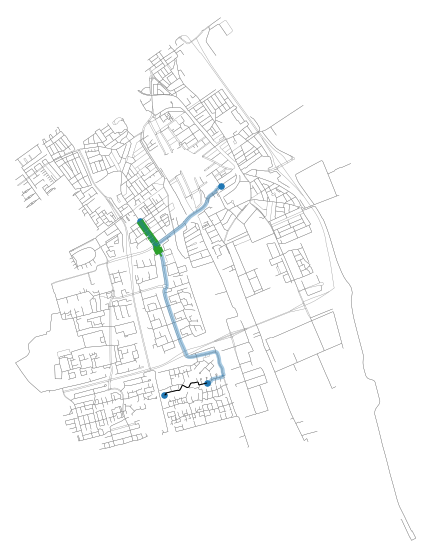

In [31]:
df = sim.runs[0].rides

for i in range(params.nV):
    paxes = df[df.veh==i].paxes
    if paxes.apply(lambda x: len(x)).max()>1:
        break
plot_veh(inData.G, df[df.veh ==19], lw = 1)

In [ ]:
params.shareability.share = 0
sim2 = simulate(params = params, inData = inData, logger_level = logging.WARNING) # simulate

In [ ]:
df = sim2.runs[0].rides

for i in range(params.nV):
    paxes = df[df.veh==i].paxes
    if paxes.apply(lambda x: len(x)).max()==1:
        break
plot_veh(inData.G, df[df.veh ==8], lw = 1)

-----